In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
import warp_prism
import sqlalchemy as sa
import talib
import matplotlib.pyplot as plt
import seaborn
pd.set_option('precision', 4)

/home/alex/env/lib/python3.6/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
metadata = sa.MetaData()
engine = sa.create_engine('postgresql://developer:1@localhost:5432/go_finance')
tbl_prices = sa.Table(
    'prices', metadata,
    sa.Column('symbol', sa.String(16)),
    sa.Column('dt', sa.Date),
    sa.Column('open', sa.FLOAT),
    sa.Column('high', sa.FLOAT),
    sa.Column('low', sa.FLOAT),
    sa.Column('close', sa.FLOAT),
    sa.Column('volume', sa.BIGINT),
    sa.Column('adj', sa.FLOAT),
)

In [3]:
symbol = 'SPY'
query = sa.select(tbl_prices.c).where(
    tbl_prices.c.symbol.in_(['SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLI', 'XLV', 'XLP', 'XLF', 'XLU', 'XLY', 'XLB'])
).where(
    tbl_prices.c.dt >= (date(2004, 1, 1) - timedelta(days=400)).strftime('%Y-%m-%d')
).order_by('symbol', 'dt')

is_adjusted = False
df = warp_prism.to_dataframe(query, bind=engine)

fltr = df['dt'] >= '2004-01-01'
print(df[fltr].iloc[0])

df.head()

symbol                    DIA
dt        2004-01-02 00:00:00
open                      105
high                    105.5
low                       104
close                   104.4
volume                8231300
adj                      73.2
Name: 275, dtype: object


,symbol,dt,open,high,low,close,volume,adj
0,DIA,2002-11-27,87.65,89.65,87.59,89.53,8264700,61.3995
1,DIA,2002-11-29,89.70,89.80,88.82,88.90,3058100,60.9675
2,DIA,2002-12-02,90.40,90.66,88.03,88.87,8928700,60.9469
3,DIA,2002-12-03,88.20,88.39,87.42,87.93,7011500,60.3023
4,DIA,2002-12-04,86.94,88.40,86.70,87.75,9947600,60.1788


In [4]:
# adjust
if not is_adjusted:
    ratio = df.adj / df.close
    df['open'] *= ratio
    df['high'] *= ratio
    df['low'] *= ratio
    df['close'] *= ratio
    df['volume'] = (df['volume'] / ratio).astype(int)
    is_adjusted = True
df.head()

,symbol,dt,open,high,low,close,volume,adj
0,DIA,2002-11-27,60.1102,61.4818,60.0691,61.3995,12051209,61.3995
1,DIA,2002-11-29,61.5161,61.5847,60.9126,60.9675,4459182,60.9675
2,DIA,2002-12-02,61.9962,62.1745,60.3708,60.9469,13019424,60.9469
3,DIA,2002-12-03,60.4874,60.6177,59.9525,60.3023,10223850,60.3023
4,DIA,2002-12-04,59.6233,60.6246,59.4587,60.1788,14505137,60.1788


# Smooth ROC

In [5]:
period = 200
roc = talib.ROC(df['close'].values, timeperiod=period)
df['roc200'] = roc
df['roc200_smooth'] = (df['roc200'] + df['roc200'].shift(1)*2 + df['roc200'].shift(2)*2 + df['roc200'].shift(3)) / 6 
df.tail()

,symbol,dt,open,high,low,close,volume,adj,roc200,roc200_smooth
47311,XLY,2018-07-23,112.13,112.25,111.420,112.03,3369156,112.03,24.0807,25.3588
47312,XLY,2018-07-24,112.71,112.89,111.440,111.70,4825617,111.70,23.0266,24.4743
47313,XLY,2018-07-25,111.39,112.56,111.060,112.52,6269782,112.52,23.7810,23.8089
47314,XLY,2018-07-26,112.40,112.79,111.691,111.93,5802016,111.93,23.5226,23.5364
47315,XLY,2018-07-27,113.41,113.57,111.140,111.64,6548826,111.64,23.3240,23.4929


In [6]:
def get_drawdown(series, is_prod=False):
    total = len(series.index)
    if is_prod:
        series = series.rolling(total, min_periods=1).apply(np.prod)
    rolling_max = series.rolling(total, min_periods=1).max()
    daily_drawdown = series/rolling_max - 1.0
    daily_drawdown_max = daily_drawdown.rolling(total, min_periods=1).min()
    return daily_drawdown_max.min()

def get_strategy_returns(df, symbol='-'):
    fltr = df['dt'] >= '2004-01-01'
    calc_returns = lambda x: (np.prod(x) - 1) * 100
    
    # get price changes
    chg = (df.close / df.close.shift(1))[fltr]
    #chg = (df.open / df.open.shift(1))[fltr]  # look in the future
    chg.iloc[0] = 1  # set first value as 1

    benchmark = chg
    sma200_chg = chg[(df.close.rolling(1).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    sma50x200_chg = chg[(df.close.rolling(50).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    
    ema50 = talib.EMA(df.close.values, timeperiod=50)
    ema200 = talib.EMA(df.close.values, timeperiod=200)
    ema50x200_chg = chg[np.roll(ema50 - ema200, 1)[fltr] >= 0]

    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200_chg = chg[np.roll(roc200, 1)[fltr] >= 0]

    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200smooth = (roc200 + np.roll(roc200, 1)*2 + np.roll(roc200, 2)*2 + np.roll(roc200, 3)) / 6
    roc200s_chg = chg[np.roll(roc200smooth, 1)[fltr] >= 0]

    roc5 = talib.ROC(df.close.values, timeperiod=5)
    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc5x200_chg = chg[np.roll(roc5 - roc200, 1)[fltr] >= 0]
    
    rsi_up = 45
    
    rsi50 = talib.RSI(df.close.values, timeperiod=50)
    rsi50_chg = chg[np.roll(rsi50, 1)[fltr] >= rsi_up]
    
    rsi100 = talib.RSI(df.close.values, timeperiod=100)
    rsi100_chg = chg[np.roll(rsi100, 1)[fltr] >= rsi_up]
    
    atr14 = talib.ATR(df.high.values, df.low.values, df.close.values, timeperiod=10)
    atr100 = talib.ATR(df.high.values, df.low.values, df.close.values, timeperiod=100)
    atr10x100_chg = chg[(np.roll(atr14 - atr100, 1)[fltr] >= 0) & (np.roll(ema50 - ema200, 1)[fltr] >= 0)]

    accum_returns_chg = chg[((df.close / df.close.shift(1)).rolling(5).apply(np.prod) - 1).shift(1) > -0.05]
    
    returns = {
        'symbol': symbol, 
        'bench': calc_returns(benchmark),
        'bench dd': get_drawdown(benchmark, is_prod=True) * 100,
        's200': calc_returns(sma200_chg[fltr]),
        's50x200': calc_returns(sma50x200_chg[fltr]),
        's50x200 dd': get_drawdown(sma50x200_chg[fltr], is_prod=True) * 100,
        'e50x200': calc_returns(ema50x200_chg[fltr]),
        'e50x200 dd': get_drawdown(ema50x200_chg[fltr], is_prod=True) * 100,
        'roc200': calc_returns(roc200_chg[fltr]),
        'roc200 dd': get_drawdown(roc200_chg[fltr], is_prod=True) * 100,
        'roc200s': calc_returns(roc200s_chg[fltr]),
        'roc5x200': calc_returns(roc5x200_chg[fltr]),
        'rsi50': calc_returns(rsi50_chg[fltr]),
        'rsi100': calc_returns(rsi100_chg[fltr]),
        'atr10x200': calc_returns(atr10x100_chg[fltr]),
        'atr10x200 dd': get_drawdown(atr10x100_chg[fltr], is_prod=True) * 100,
        'accum_returns': calc_returns(accum_returns_chg[fltr]),
        'accum_returns dd': get_drawdown(accum_returns_chg[fltr], is_prod=True) * 100,
    }
    return returns

l = []
for symbol in df.symbol.unique():
    l.append(get_strategy_returns(df[df.symbol == symbol], symbol))
    
print("Returns & Drawdowns")
pd.DataFrame(l).sort_values('symbol')

Returns & Drawdowns


,accum_returns,accum_returns dd,atr10x200,atr10x200 dd,bench,bench dd,e50x200,e50x200 dd,roc200,roc200 dd,roc200s,roc5x200,rsi100,rsi50,s200,s50x200,s50x200 dd,symbol
0,146.4705,-59.9308,86.4040,-21.7240,247.3549,-51.8693,232.4472,-19.5597,182.7239,-23.3394,176.4665,-6.0815,179.4539,82.9528,131.7483,242.7484,-23.7096,DIA
1,125.6609,-61.4908,78.8635,-33.8289,258.9133,-59.0453,205.5246,-26.6661,105.2440,-39.9853,127.5652,32.4152,189.7682,132.1991,91.9759,128.1219,-37.8055,IWM
2,298.7327,-55.8906,80.6642,-34.2166,449.2185,-53.4040,293.3163,-29.3527,185.4135,-26.9391,246.6562,55.5594,493.5509,362.9509,214.4664,222.6239,-26.0499,QQQ
3,136.8651,-62.9395,76.9021,-26.2189,238.3322,-55.1894,217.3874,-18.9325,148.1305,-33.6410,135.5910,-2.6295,172.7481,108.5841,156.2134,237.6766,-19.1790,SPY
4,176.2304,-57.7672,72.8101,-19.7843,209.0119,-59.8292,151.6207,-29.2318,78.3873,-41.8105,126.1530,27.3490,264.7156,156.9499,21.4902,152.9559,-24.9551,XLB
5,-41.3002,-85.5798,130.8055,-24.5405,66.4133,-82.6872,178.3847,-28.2106,105.5202,-39.7909,98.6063,-29.5409,-3.3610,5.8314,109.9118,192.1724,-30.2858,XLF
6,260.7201,-51.5022,111.6087,-29.8344,278.8415,-62.2632,276.7834,-23.6545,234.7571,-27.6842,200.4164,16.5627,274.3244,336.1671,188.3324,202.0258,-30.0123,XLI
7,177.6174,-60.8777,76.7626,-29.6930,327.4674,-53.0393,223.6129,-24.6339,133.8084,-30.4945,125.9467,53.3337,284.6116,223.5144,186.3736,158.5683,-24.5829,XLK
8,174.0348,-43.3011,90.7417,-24.5285,255.4141,-32.3903,183.2995,-21.8896,154.6579,-18.6106,216.6045,12.1571,192.2344,112.1370,94.6595,124.1684,-26.1855,XLP
9,183.5787,-54.0481,48.9725,-25.5331,281.7813,-46.4766,220.8833,-24.9148,175.5467,-22.1493,220.2546,9.8375,303.9590,204.9969,96.5175,205.2229,-23.3583,XLU


Returns:  3.38332215257 Max Drawdown:  -0.551894401605 -0.551894401605


/home/alex/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


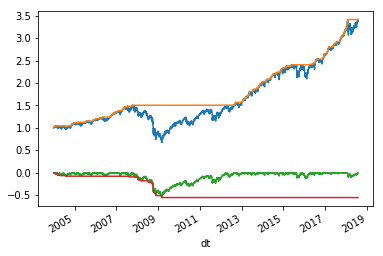

In [7]:
fltr = df['dt'] >= '2004-01-01'
data = df[fltr][df.symbol == 'SPY'].set_index('dt')
chg = (data.close / data.close.shift(1))
chg.iloc[0] = 1

total = len(chg.index)
chg = chg.rolling(total, min_periods=1).apply(np.prod)
rolling_max = chg.rolling(total, min_periods=1).max()
daily_drawdown = chg/rolling_max - 1.0
daily_drawdown_max = daily_drawdown.rolling(total, min_periods=1).min()
print('Returns: ', chg.iloc[-1], 'Max Drawdown: ', daily_drawdown_max.min(), get_drawdown(data.close))

chg.plot()
rolling_max.plot()
daily_drawdown.plot()
daily_drawdown_max.plot()
plt.show()

In [9]:
import io
tsv = """
	name	return	max drawdown	exposure	total_orders_buy	total_orders_sell
0	SPY, sma50x200	224.21	-19.43	79.492081	51	8
1	SPY, KST>0	106.17	-19.47	67.821107	77	51
2	SPY, KST>KST signal	15.55	-30.80	47.695664	117	109
3	SPY, ROC200 & TSI>0.5	122.51	-28.48	65.182960	84	50
4	SPY, ROC5 by SMA(200)	184.36	-24.77	84.837742	66	13
"""
df = pd.read_csv(io.StringIO(tsv), sep='\t', header=0)

df['orders'] = df['total_orders_buy'] + df['total_orders_sell']
df['transactions'] = df['total_orders_sell'] * 2

df[['name', 'return', 'max drawdown', 'exposure', 'transactions']].sort_values('return', ascending=False)

,name,return,max drawdown,exposure,transactions
0,"SPY, sma50x200",224.21,-19.43,79.4921,16
4,"SPY, ROC5 by SMA(200)",184.36,-24.77,84.8377,26
3,"SPY, ROC200 & TSI>0.5",122.51,-28.48,65.1830,100
1,"SPY, KST>0",106.17,-19.47,67.8211,102
2,"SPY, KST>KST signal",15.55,-30.80,47.6957,218


In [9]:
def get_strategy_returns(df, symbol='-'):
    # фильтр периода
    fltr = df['dt'] >= '2004-01-01'
    # функция накопления доходности
    calc_returns = lambda x: (np.prod(x) - 1) * 100
    
    # получаем дневное изменение цены и оставляем необходимый период
    chg = (df.close / df.close.shift(1))[fltr]
    chg.iloc[0] = 1  # начинаем всегда с единицы

    benchmark = chg
    sma200_chg = chg[(df.close.rolling(1).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    sma50x200_chg = chg[(df.close.rolling(50).mean() - df.close.rolling(200).mean()).shift(1) >= 0]
    
    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200_chg = chg[np.roll(roc200, 1)[fltr] >= 0]

    roc200 = talib.ROC(df.close.values, timeperiod=200)
    roc200smooth = (roc200 + np.roll(roc200, 1)*2 + np.roll(roc200, 2)*2 + np.roll(roc200, 3)) / 6
    roc200s_chg = chg[np.roll(roc200smooth, 1)[fltr] >= 0]
    
    returns = {
        'symbol': symbol, 
        'bench': calc_returns(benchmark),
        'bench dd': get_drawdown(benchmark, is_prod=True) * 100,
        's200': calc_returns(sma200_chg[fltr]),
        's200 dd': get_drawdown(sma200_chg[fltr], is_prod=True) * 100,
        's50x200': calc_returns(sma50x200_chg[fltr]),
        's50x200 dd': get_drawdown(sma50x200_chg[fltr], is_prod=True) * 100,
        'roc200': calc_returns(roc200_chg[fltr]),
        'roc200 dd': get_drawdown(roc200_chg[fltr], is_prod=True) * 100,
        'roc200s': calc_returns(roc200s_chg[fltr]),
        'roc200s dd': get_drawdown(roc200s_chg[fltr], is_prod=True) * 100,
    }
    return returns
l = []
for symbol in df.symbol.unique():
    l.append(get_strategy_returns(df[df.symbol == symbol], symbol))
    
print("Returns & Drawdowns")
pd.DataFrame(l).sort_values('symbol')

Returns & Drawdowns


,bench,bench dd,roc200,roc200 dd,roc200s,roc200s dd,s200,s200 dd,s50x200,s50x200 dd,symbol
0,247.3549,-51.8693,182.7239,-23.3394,176.4665,-20.4875,131.7483,-20.7875,242.7484,-23.7096,DIA
1,258.9133,-59.0453,105.2440,-39.9853,127.5652,-34.3266,91.9759,-28.7601,128.1219,-37.8055,IWM
2,449.2185,-53.4040,185.4135,-26.9391,246.6562,-24.9958,214.4664,-26.4412,222.6239,-26.0499,QQQ
3,238.3322,-55.1894,148.1305,-33.6410,135.5910,-32.4676,156.2134,-20.6767,237.6766,-19.1790,SPY
4,209.0119,-59.8292,78.3873,-41.8105,126.1530,-29.9843,21.4902,-45.3152,152.9559,-24.9551,XLB
5,66.4133,-82.6872,105.5202,-39.7909,98.6063,-41.7358,109.9118,-30.8172,192.1724,-30.2858,XLF
6,278.8415,-62.2632,234.7571,-27.6842,200.4164,-32.9876,188.3324,-24.4730,202.0258,-30.0123,XLI
7,327.4674,-53.0393,133.8084,-30.4945,125.9467,-26.0254,186.3736,-22.3531,158.5683,-24.5829,XLK
8,255.4141,-32.3903,154.6579,-18.6106,216.6045,-16.6489,94.6595,-20.8217,124.1684,-26.1855,XLP
9,281.7813,-46.4766,175.5467,-22.1493,220.2546,-15.4840,96.5175,-24.5642,205.2229,-23.3583,XLU


In [10]:
fltr = df['dt'] >= '2004-01-01'
prices = df[df.symbol == 'SPY'].open  # look in the future
# prices = df[df.symbol == 'SPY'].close

# Расчёт доходности

SPY Returns: 239.53% PriceXSMA200: 589.35% SMA50X200: 235.45%


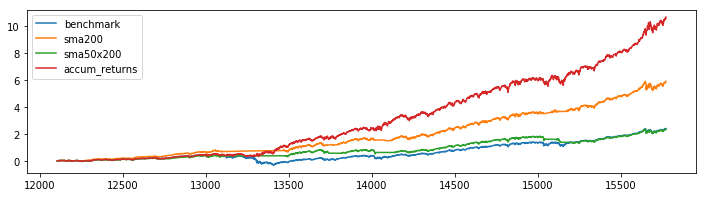

In [12]:
calc_returns = lambda x: (np.prod(x) - 1) * 100  # считаем итоговую доходность
    
# получаем дневное изменение цены
chg = (prices / prices.shift(1))[fltr]
chg.iloc[0] = 1  # начинаем всегда с единицы

# получаем пересечение цены и SMA200, и смещаем на 1 день вперёд
filter_changes = (df.close.rolling(1).mean() - df.close.rolling(200).mean()).shift(1) >= 0
sma200 = chg[filter_changes]

# получаем пересечение SMA50 и SMA200, и смещаем на 1 день вперёд
filter_changes = (df.close.rolling(50).mean() - df.close.rolling(200).mean()).shift(1) >= 0
sma50x200 = chg[filter_changes]

filter_changes = ((df.close / df.close.shift(1)).rolling(5).apply(np.prod) - 1).shift(1) > -0.05
accum_returns = chg[filter_changes]

print('SPY Returns: {bench:.2f}% PriceXSMA200: {sma200:.2f}% SMA50X200: {sma50x200:.2f}%'.format(
    bench=calc_returns(chg), sma200=calc_returns(sma200), sma50x200=calc_returns(sma50x200)))

(chg.rolling(total, min_periods=1).apply(np.prod) - 1).rename('benchmark').plot(figsize=(12, 3), legend=True)
(sma200.rolling(total, min_periods=1).apply(np.prod) - 1).rename('sma200').plot(legend=True)
(sma50x200.rolling(total, min_periods=1).apply(np.prod) - 1).rename('sma50x200').plot(legend=True)
(accum_returns.rolling(total, min_periods=1).apply(np.prod) - 1).rename('accum_returns').plot(legend=True)
plt.show()

# Расчёт максимальной просадки

SPY Drawdown: -55.19%


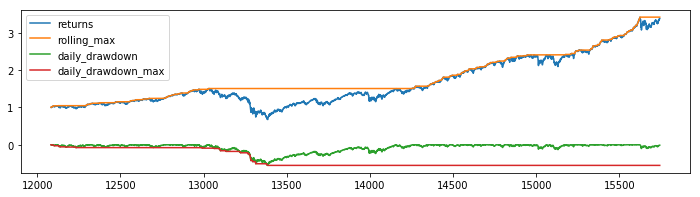

In [18]:
series = chg.copy()
total = len(series.index)
# получаем доходность на каждый день
series = series.rolling(total, min_periods=1).apply(np.prod)
# получаем обновление максимумов на каждый день
rolling_max = series.rolling(total, min_periods=1).max()
# получаем разницу максимума к цене на каждый день
daily_drawdown = series/rolling_max - 1.0
# получаем обновление минимумов просадки на каждый день
daily_drawdown_max = daily_drawdown.rolling(total, min_periods=1).min()
# выводим максимальную просадку
print('SPY Drawdown: {0:.2f}%'.format(daily_drawdown_max.min() * 100))

series.rename('returns').plot(figsize=(12, 3), legend=True)
rolling_max.rename('rolling_max').plot(legend=True)
daily_drawdown.rename('daily_drawdown').plot(legend=True)
daily_drawdown_max.rename('daily_drawdown_max').plot(legend=True)
plt.show()